In [22]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils

In [11]:
from scipy import ndimage

In [142]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jcharyton (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Paths definition

In [2]:
train_data_directory = r'train_data'
test_data_directory = r'test_data'
saved_models_directory = r'saved_models'
submissions_directory = r'submissions'

### Dataset testing

In [3]:
all_files = np.array(
    sorted(
        glob(os.path.join(train_data_directory, 'train_data', "*.npz")),
        key=lambda x: int(os.path.basename(x).replace(".npz", "")),
    )
)

In [4]:
all_files

array(['train_data/train_data/0.npz', 'train_data/train_data/1.npz',
       'train_data/train_data/2.npz', ...,
       'train_data/train_data/1729.npz', 'train_data/train_data/1730.npz',
       'train_data/train_data/1731.npz'], dtype='<U30')

In [15]:
arr = np.ma.MaskedArray(**np.load(all_files[2]))
arr.shape

(150, 11, 11)

In [16]:
arr.mask[0].shape

(11, 11)

In [17]:
arr.mask[0]

array([[ True,  True,  True,  True, False, False, False, False,  True,
         True,  True],
       [ True,  True,  True, False, False, False, False, False, False,
         True,  True],
       [ True,  True, False, False, False, False, False, False, False,
        False,  True],
       [ True, False, False, False, False, False, False, False, False,
        False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False],
       [ True,  True, False, False, False, False, False, False, False,
        False,  True],
       [ True,  True, False, False, False, False, False, False, False,
        False,  True],
       [ True,  True,  True,  True, False, False, False, False,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  Tr

In [23]:
xcenter, ycenter = ndimage.center_of_mass(arr.mask[0])
xcenter = round(xcenter)
ycenter = round(ycenter)
xcenter, ycenter

(6, 4)

In [26]:
arr.mask[0].shape

(11, 11)

In [38]:
arr.mask[0][xcenter-3:xcenter+3, ycenter-3:ycenter+3].shape

(6, 6)

In [80]:
arr.shape[1], arr.shape[2]

(93, 115)

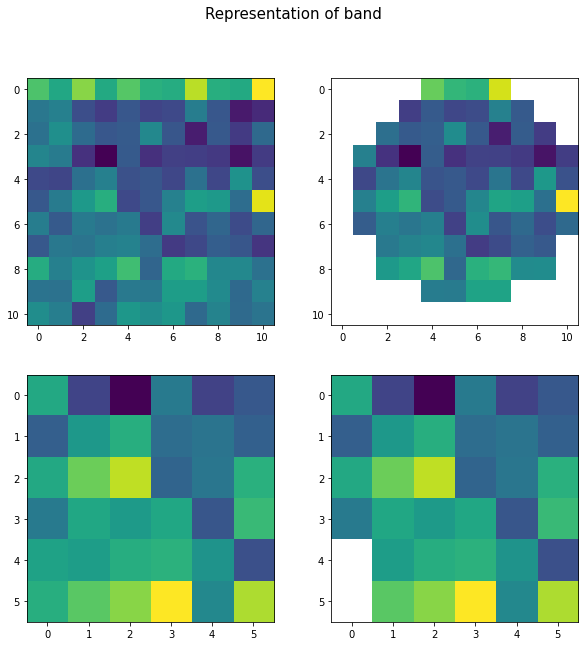

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
band_id = 145

axs[0,0].imshow(arr[band_id,:,:].data)
axs[0,1].imshow(arr[band_id,:,:])

axs[1,0].imshow(arr[band_id,xcenter-3:xcenter+3,ycenter-3:ycenter+3].data)
axs[1,1].imshow(arr[band_id,xcenter-3:xcenter+3,ycenter-3:ycenter+3])
plt.suptitle(f'Representation of band', fontsize=15)
plt.show()

In [39]:
tensor_data = torch.as_tensor(arr)
tensor_data

tensor([[[ 415,  417,  426,  ...,  449,  437,  469],
         [ 400,  404,  412,  ...,  431,  422,  417],
         [ 413,  423,  403,  ...,  419,  421,  444],
         ...,
         [ 427,  434,  422,  ...,  429,  428,  446],
         [ 414,  430,  441,  ...,  467,  440,  440],
         [ 430,  417,  427,  ...,  438,  444,  420]],

        [[ 405,  416,  427,  ...,  448,  437,  471],
         [ 411,  412,  409,  ...,  425,  422,  424],
         [ 412,  422,  394,  ...,  417,  410,  440],
         ...,
         [ 423,  428,  417,  ...,  423,  423,  440],
         [ 418,  431,  432,  ...,  453,  435,  437],
         [ 427,  415,  419,  ...,  433,  434,  426]],

        [[ 402,  421,  416,  ...,  448,  439,  467],
         [ 408,  399,  401,  ...,  422,  418,  421],
         [ 406,  409,  389,  ...,  413,  408,  424],
         ...,
         [ 414,  420,  413,  ...,  415,  424,  433],
         [ 409,  423,  427,  ...,  441,  428,  428],
         [ 420,  418,  409,  ...,  433,  427,  428]],

In [42]:
tensor_data.shape

torch.Size([150, 11, 11])

In [90]:
tensor_mask_bool = ~torch.as_tensor(arr.mask)
tensor_mask_bool

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True, False, False],
         [False, False,  True,  ...,  True,  True, False],
         ...,
         [False, False,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True, False, False],
         [False, False,  True,  ...,  True,  True, False],
         ...,
         [False, False,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True, False, False],
         [False, False,  True,  ...,  True,  True, False],
         ...,
         [False, False,  True,  ...,  True,  True, False],
         [

In [75]:
tensor_mask_bool_array = tensor_mask_bool.cpu().numpy()

In [76]:
tensor_mask_bool.shape

torch.Size([150, 11, 11])

In [77]:
tensor_data_masked = torch.mul(tensor_data, tensor_mask_bool)
tensor_data_masked

tensor([[[   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,  431,    0,    0],
         [   0,    0,  403,  ...,  419,  421,    0],
         ...,
         [   0,    0,  422,  ...,  429,  428,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]],

        [[   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,  425,    0,    0],
         [   0,    0,  394,  ...,  417,  410,    0],
         ...,
         [   0,    0,  417,  ...,  423,  423,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]],

        [[   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,  422,    0,    0],
         [   0,    0,  389,  ...,  413,  408,    0],
         ...,
         [   0,    0,  413,  ...,  415,  424,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]],

In [78]:
tensor_data_masked_array = tensor_data_masked.cpu().numpy()

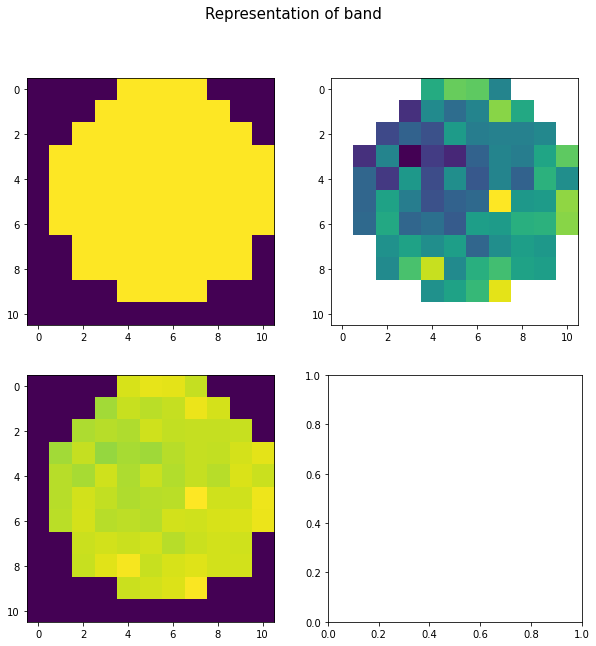

In [79]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].imshow(tensor_mask_bool_array[0,:,:].data)
axs[0,1].imshow(arr[0,:,:])

axs[1,0].imshow(tensor_data_masked_array[0,:,:])
plt.suptitle(f'Representation of band', fontsize=15)
plt.show()

In [46]:
tensor_data_masked.shape

torch.Size([150, 11, 11])

In [47]:
def pad_to_minimum_size(min_size, image):
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2
        print(h_diff, w_diff)
        
        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)
        
        print(h_pad1, h_pad2, w_pad1, w_pad2)
        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)
    

In [48]:
pad_to_minimum_size(300, tensor_data_masked).shape

144.5 144.5
144 145 144 145


torch.Size([150, 300, 300])

In [80]:
tensor_mask_bool[0]

tensor([[False, False, False, False,  True,  True,  True,  True, False, False,
         False],
        [False, False, False,  True,  True,  True,  True,  True,  True, False,
         False],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [False, False, False, False,  True,  True,  True,  True, False, False,
         False],
        [False, False, False, False, Fal

In [81]:
padded_mask = pad_to_minimum_size(300, tensor_mask_bool)
padded_mask.shape

144.5 144.5
144 145 144 145


torch.Size([150, 300, 300])

In [82]:
xcenter, ycenter = ndimage.center_of_mass(padded_mask.cpu().numpy()[0])
xcenter = round(xcenter)
ycenter = round(ycenter)
xcenter, ycenter

(149, 150)

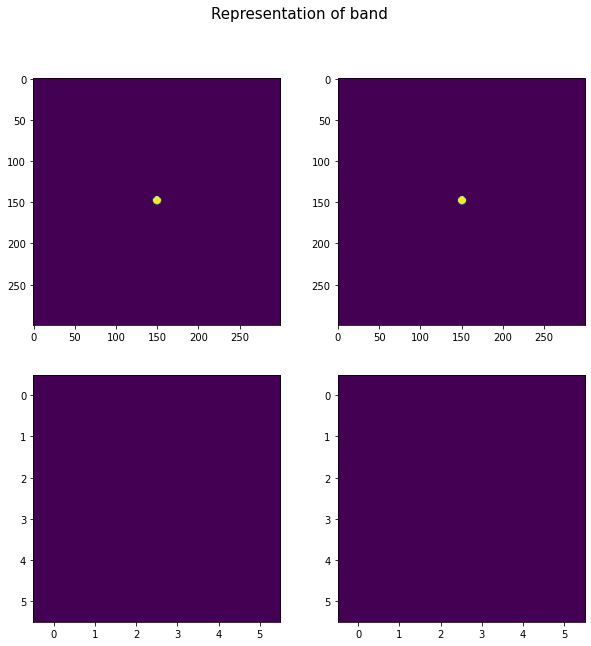

In [83]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].imshow(padded_mask.cpu().numpy()[0,:,:].data)
axs[0,1].imshow(padded_mask.cpu().numpy()[0,:,:])

axs[1,0].imshow(padded_mask.cpu().numpy()[0,xcenter-3:xcenter+3,ycenter-3:ycenter+3].data)
axs[1,1].imshow(padded_mask.cpu().numpy()[0,xcenter-3:xcenter+3,ycenter-3:ycenter+3])
plt.suptitle(f'Representation of band', fontsize=15)
plt.show()

In [84]:
padded_mask.cpu().numpy()[0,xcenter-3:xcenter+3,ycenter-3:ycenter+3]

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

### Load mean and std values of training dataset

In [85]:
means_stds_arrays = np.load(os.path.join(train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

In [86]:
tensor_data_masked_normalized = transforms.functional.normalize(torch.as_tensor(tensor_data_masked, dtype=torch.float), mean=means.tolist(), std=stds.tolist())
tensor_data_masked_normalized

tensor([[[-10.0814, -10.0814, -10.0814,  ..., -10.0814, -10.0814, -10.0814],
         [-10.0814, -10.0814, -10.0814,  ...,   1.3321, -10.0814, -10.0814],
         [-10.0814, -10.0814,   0.5906,  ...,   1.0143,   1.0673, -10.0814],
         ...,
         [-10.0814, -10.0814,   1.0937,  ...,   1.2791,   1.2526, -10.0814],
         [-10.0814, -10.0814, -10.0814,  ..., -10.0814, -10.0814, -10.0814],
         [-10.0814, -10.0814, -10.0814,  ..., -10.0814, -10.0814, -10.0814]],

        [[-10.0445, -10.0445, -10.0445,  ..., -10.0445, -10.0445, -10.0445],
         [-10.0445, -10.0445, -10.0445,  ...,   1.1830, -10.0445, -10.0445],
         [-10.0445, -10.0445,   0.3641,  ...,   0.9717,   0.7868, -10.0445],
         ...,
         [-10.0445, -10.0445,   0.9717,  ...,   1.1302,   1.1302, -10.0445],
         [-10.0445, -10.0445, -10.0445,  ..., -10.0445, -10.0445, -10.0445],
         [-10.0445, -10.0445, -10.0445,  ..., -10.0445, -10.0445, -10.0445]],

        [[ -9.9486,  -9.9486,  -9.9486,  ...

In [87]:
temp_gt = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[['P','K','Mg','pH']]

In [88]:
temp_gt

,P,K,Mg,pH
0,45.1,188.0,179.0,7.2
1,44.8,205.0,188.0,7.0
2,44.4,207.0,145.0,6.8
3,46.5,204.0,143.0,6.8
4,52.0,212.0,167.0,6.7
...,...,...,...,...
1727,40.8,133.0,132.0,6.2
1728,42.7,192.0,126.0,6.5
1729,39.4,180.0,122.0,6.5
1730,37.3,162.0,127.0,6.5


In [89]:
temp_gt.loc[1, 'P']

44.8

### Dataset definition

In [105]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=True, means=None, stds=None, train_transforms=False):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['P','K','Mg','pH']]
        else:
            self.gt = None
        self.transform = transform # whether to perform transformation of input data
        self.train_transforms = train_transforms # whether to perform transformations like on training data
        
        if self.train_transforms:
            self.training_transforms_composition = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.4), transforms.RandomVerticalFlip(p=0.4)])
        
        self.means = means # mean values for every band used to normalize data
        self.stds = stds # std values for every band used to normalize data
        
        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )
    
    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2
        
        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)
        
        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float) 
        img_tensor_mask = ~torch.as_tensor(img_arr.mask) # Inverting mask is necessary due to masking method in numpy
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)
        
        if self.transform:
            img_masked_tensor_transformed = transforms.functional.normalize(img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_transformed = self.pad_to_minimum_size(300, img_masked_tensor_transformed)
            if self.train_transforms:
                img_masked_tensor_transformed = self.training_transforms_composition(img_masked_tensor_transformed)
            img_result_tensor = img_masked_tensor_transformed
        else:
            img_result_tensor = img_masked_tensor
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']

            sample = {'image': img_result_tensor, 'P': P_gt, 'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt}
        else:
            sample = {'image': img_result_tensor}
        
        return sample

In [116]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(train_data_directory, 'train_data'), True, means, stds, train_transforms=True)

In [117]:
train_dataset, validation_dataset = random_split(train_data_whole, [1400, 332])

### Model Definition

In [118]:
import torchvision
from torchvision import datasets, models, transforms

In [119]:
class ResNetCNN(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        self.resnet_model = models.resnet50(pretrained=False)
        
        self.resnet_model.conv1 = nn.Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet_model.fc = nn.Linear(2048, 4, bias=True)
        
    def forward(self, x):
        x = self.resnet_model(x)
#         return {'P': x[0], 'K': x[1], 'Mg': x[2], 'pH': x[3]}
        return x

In [120]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [121]:
BATCH_SIZE = 12
EPOCHS = 300

In [122]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4)

### Overfitting on single batch of data

In [123]:
model = ResNetCNN(pretrained=False)
model.to(device)

ResNetCNN(
  (resnet_model): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [124]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [125]:
train_data_single_batch = next(iter(train_dataloader))

In [126]:
train_data_single_batch

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

In [127]:
train_data_single_batch['image'][0].shape

torch.Size([150, 300, 300])

In [128]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([12, 150, 300, 300])

In [129]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float))

In [130]:
output

tensor([[ 0.2348, -0.0808, -0.1019,  0.2218],
        [ 0.2904, -0.2684,  0.0649,  0.3380],
        [ 0.6069, -0.6332,  0.5487,  0.6868],
        [ 0.5204, -0.9087,  0.7720,  0.8268],
        [ 0.6301, -0.5861,  0.5630,  0.5244],
        [ 0.5373, -0.5591,  0.4630,  0.5560],
        [ 0.4915, -0.4245,  0.4707,  0.4758],
        [ 0.2472, -0.1076, -0.0116,  0.2186],
        [ 0.2036, -0.1250,  0.0275,  0.2731],
        [ 0.2418, -0.1367,  0.0090,  0.2947],
        [ 0.3697, -0.5276,  0.3968,  0.4650],
        [ 0.5993, -1.0284,  0.7817,  0.6514]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [131]:
stacked_gt = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'], train_data_single_batch['Mg'], train_data_single_batch['pH']))
stacked_gt

tensor([[ 96.0000,  78.2000,  67.5000,  36.7000,  52.4000,  84.0000,  44.3000,
          66.9000,  44.5000,  57.3000,  27.8000,  46.0000],
        [190.0000, 262.0000, 189.0000, 333.0000, 139.0000, 210.0000, 188.0000,
         176.0000, 204.0000, 231.0000, 237.0000, 195.0000],
        [105.0000, 140.0000, 129.0000, 209.0000, 141.0000, 120.0000, 137.0000,
         115.0000, 176.0000, 240.0000, 173.0000, 201.0000],
        [  6.3000,   6.7000,   6.5000,   6.6000,   6.7000,   7.3000,   6.7000,
           7.3000,   6.7000,   6.8000,   6.9000,   7.0000]],
       dtype=torch.float64)

In [132]:
stacked_gt = stacked_gt.transpose(0, 1).to(device)

In [133]:
stacked_gt

tensor([[ 96.0000, 190.0000, 105.0000,   6.3000],
        [ 78.2000, 262.0000, 140.0000,   6.7000],
        [ 67.5000, 189.0000, 129.0000,   6.5000],
        [ 36.7000, 333.0000, 209.0000,   6.6000],
        [ 52.4000, 139.0000, 141.0000,   6.7000],
        [ 84.0000, 210.0000, 120.0000,   7.3000],
        [ 44.3000, 188.0000, 137.0000,   6.7000],
        [ 66.9000, 176.0000, 115.0000,   7.3000],
        [ 44.5000, 204.0000, 176.0000,   6.7000],
        [ 57.3000, 231.0000, 240.0000,   6.8000],
        [ 27.8000, 237.0000, 173.0000,   6.9000],
        [ 46.0000, 195.0000, 201.0000,   7.0000]], device='cuda:0',
       dtype=torch.float64)

In [134]:
loss_func(output, stacked_gt)

tensor(19437.4972, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

In [139]:
img_data_device = train_data_single_batch['image'].to(device, dtype=torch.float)
stacked_gt_device = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'], train_data_single_batch['Mg'], train_data_single_batch['pH'])).transpose(0,1).to(device, 
    dtype=torch.float)

model = ResNetCNN(False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
loss_func = torch.nn.MSELoss()

for epoch in range(301):
    model.train()
    
    output = model(img_data_device)
    loss = loss_func(output, stacked_gt_device)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()

    # Calculate MSE for each class
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
    
    if epoch%10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}')

epoch: 0, loss: 19460.16796875, MSE: [ 3752.0625   47597.203    26442.916       48.486233]
epoch: 10, loss: 1025.81689453125, MSE: [ 548.375    1910.8319   1628.3885     15.671758]
epoch: 20, loss: 560.198486328125, MSE: [ 525.3868     430.9927    1282.1996       2.2149282]
epoch: 30, loss: 472.72723388671875, MSE: [ 437.1727     315.16217   1137.0692       1.5048118]
epoch: 40, loss: 331.90521240234375, MSE: [338.59842   385.29288   602.52295     1.2064289]
epoch: 50, loss: 304.9484558105469, MSE: [2.5606287e+02 3.2660849e+02 6.3667987e+02 4.4253489e-01]
epoch: 60, loss: 287.89044189453125, MSE: [2.1335658e+02 3.1384702e+02 6.2417340e+02 1.8471634e-01]
epoch: 70, loss: 278.62835693359375, MSE: [1.7550581e+02 3.6083719e+02 5.7799561e+02 1.7479730e-01]
epoch: 80, loss: 266.0010681152344, MSE: [1.2881911e+02 3.8505103e+02 5.4997113e+02 1.6299759e-01]
epoch: 90, loss: 291.44793701171875, MSE: [8.7194557e+01 6.2935663e+02 4.4903711e+02 2.0336662e-01]
epoch: 100, loss: 241.65411376953125, M

### Training

In [143]:
model_name = 'Proper_Data_resnet50_BATCHSIZE_12_AdamW_LR_0_01_ReduceLROnPlateau_Factor0_6_Threshold_0_0001'

In [144]:
model = ResNetCNN(False).to(device)

In [145]:
wandb.watch(model, log="None", log_freq=20)

[]

In [148]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [149]:
loss_func = torch.nn.MSELoss()

#### Find LR

In [150]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [151]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float), 
                torch.as_tensor(torch.stack((batch_data['P'], batch_data['K'], batch_data['Mg'], batch_data['pH'])).transpose(0,1), dtype=torch.float))

In [152]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader), start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 5.72E-03


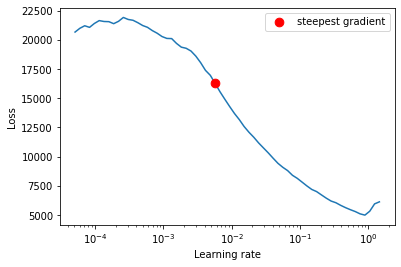

In [153]:
lr_finder.plot()
lr_finder.reset()

In [159]:
5.72E-03

0.00572

#### Continue training

In [160]:
patience_scheduler_overfit = 5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.6, patience = patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [161]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                               path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

In [162]:
config = wandb.config
config.model = 'resnet50'
config.optimizer =  'AdamW'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler =  'ReduceLROnPlateau'
config.scheduler_factor =  0.6
config.scheduler_patience =  5
config.scheduler_threshold =  0.0001
config.batch_size = BATCH_SIZE
config.notes = 'Proper data after mask fix.'

In [163]:
previous_epochs = 0 # how many epochs have been done previously if resuming

In [164]:
for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []
    
    bar = tqdm(train_dataloader, position=0, leave=False, desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar: # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
        stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(0,1).to(device, dtype=torch.float)
        
        output = model(img_data_device)
        
        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)
        
        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()
        
        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_train_list.append(mse)
        
        if i % 10 == 0: # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss 
            train_log_dict['train_batch_MSE_P'] = mse[0]
            train_log_dict['train_batch_MSE_K'] = mse[1]
            train_log_dict['train_batch_MSE_Mg'] = mse[2]
            train_log_dict['train_batch_MSE_pH'] = mse[3]
            wandb.log(train_log_dict)
    
    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(np.array(mse_train_list)).mean(axis=0).numpy().tolist()
    
    print(f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}')
    wandb.log({'epoch': epoch, 'average_train_loss':avg_train_loss, 'average_train_MSE_P': avg_train_mse[0], 'average_train_MSE_K': avg_train_mse[1],
              'average_train_MSE_Mg': avg_train_mse[2], 'average_train_MSE_pH': avg_train_mse[3]})
    
    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0, leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
            stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(0,1).to(device, dtype=torch.float)
            
            output = model(img_data_device)
            
            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)
            
            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(np.array(mse_val_list)).mean(axis=0).numpy().tolist()
        
        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}')
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_val_MSE_P': avg_val_mse[0], 'average_val_MSE_K': avg_val_mse[1], 
                   'average_val_MSE_Mh': avg_val_mse[2], 'average_val_MSE_pH': avg_val_mse[3]})
        
        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break


epoch 0 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 0, LR: 0.01, train loss: 2352.13720703125, train MSE: [1261.6715087890625, 5669.75732421875, 2468.3291015625, 8.790243148803711]


epoch 0 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 0, validation loss: 1333.250244140625, validation MSE: [769.3485107421875, 3222.719970703125, 1340.70263671875, 0.2294091135263443]
Validation loss decreased (inf --> 1333.250244).  Saving model ...


epoch 1 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 1, LR: 0.01, train loss: 1691.8419189453125, train MSE: [968.7906494140625, 4048.744873046875, 1749.6241455078125, 0.2078319638967514]


epoch 1 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 1, validation loss: 1287.188720703125, validation MSE: [719.584716796875, 3031.2412109375, 1397.7137451171875, 0.21445401012897491]
Validation loss decreased (1333.250244 --> 1287.188721).  Saving model ...


epoch 2 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 2, LR: 0.01, train loss: 1686.92822265625, train MSE: [975.2186889648438, 4018.952392578125, 1753.2928466796875, 0.24862141907215118]


epoch 2 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 2, validation loss: 1290.2958984375, validation MSE: [700.6502685546875, 3055.86572265625, 1404.586669921875, 0.08123062551021576]
EarlyStopping counter: 1 out of 13


epoch 3 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 3, LR: 0.01, train loss: 1663.1783447265625, train MSE: [968.4693603515625, 3951.222412109375, 1732.8111572265625, 0.2103593498468399]


epoch 3 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 3, validation loss: 1336.8118896484375, validation MSE: [731.475830078125, 3240.045166015625, 1375.6241455078125, 0.10261306166648865]
EarlyStopping counter: 2 out of 13


epoch 4 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 4, LR: 0.01, train loss: 1669.5994873046875, train MSE: [976.012939453125, 3985.872802734375, 1716.2921142578125, 0.22028516232967377]


epoch 4 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 4, validation loss: 1337.4429931640625, validation MSE: [732.0747680664062, 3272.560791015625, 1344.2860107421875, 0.8504877686500549]
EarlyStopping counter: 3 out of 13


epoch 5 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 5, LR: 0.01, train loss: 1653.4881591796875, train MSE: [966.8953247070312, 3935.003662109375, 1711.8359375, 0.21708150207996368]


epoch 5 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 5, validation loss: 1285.1861572265625, validation MSE: [717.40478515625, 3097.567138671875, 1325.5335693359375, 0.23901861906051636]
Validation loss decreased (1287.188721 --> 1285.186157).  Saving model ...


epoch 6 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 6, LR: 0.01, train loss: 1660.7659912109375, train MSE: [966.1392822265625, 3964.494140625, 1712.2503662109375, 0.18026621639728546]


epoch 6 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 6, validation loss: 1233.187744140625, validation MSE: [670.3176879882812, 2945.075439453125, 1317.2734375, 0.08446202427148819]
Validation loss decreased (1285.186157 --> 1233.187744).  Saving model ...


epoch 7 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 7, LR: 0.01, train loss: 1657.4189453125, train MSE: [961.7968139648438, 3967.525146484375, 1700.1976318359375, 0.15603843331336975]


epoch 7 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 7, validation loss: 1421.9063720703125, validation MSE: [748.330810546875, 3600.630126953125, 1338.3531494140625, 0.3113895058631897]
EarlyStopping counter: 1 out of 13


epoch 8 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 8, LR: 0.01, train loss: 1667.83740234375, train MSE: [960.1514282226562, 4028.1904296875, 1682.8631591796875, 0.14452289044857025]


epoch 8 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 8, validation loss: 1264.946533203125, validation MSE: [663.300048828125, 3076.644775390625, 1319.7833251953125, 0.05840365216135979]
EarlyStopping counter: 2 out of 13


epoch 9 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 9, LR: 0.01, train loss: 1646.0875244140625, train MSE: [955.1336059570312, 3929.36962890625, 1699.69580078125, 0.1513826549053192]


epoch 9 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 9, validation loss: 1277.02978515625, validation MSE: [670.6549682617188, 3090.064208984375, 1347.239990234375, 0.16005955636501312]
EarlyStopping counter: 3 out of 13


epoch 10 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 10, LR: 0.01, train loss: 1668.0684814453125, train MSE: [955.2772827148438, 4025.9833984375, 1690.87841796875, 0.1336018443107605]


epoch 10 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 10, validation loss: 1289.0543212890625, validation MSE: [675.443603515625, 3139.392333984375, 1341.28759765625, 0.0936574786901474]
EarlyStopping counter: 4 out of 13


epoch 11 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 11, LR: 0.01, train loss: 1657.13916015625, train MSE: [953.1100463867188, 3981.502197265625, 1693.8182373046875, 0.1266758292913437]


epoch 11 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 11, validation loss: 1269.7091064453125, validation MSE: [664.2022094726562, 3062.88720703125, 1351.676513671875, 0.07017318159341812]
EarlyStopping counter: 5 out of 13


epoch 12 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 12, LR: 0.01, train loss: 1682.3865966796875, train MSE: [958.661865234375, 4043.82275390625, 1726.9169921875, 0.14439551532268524]


epoch 12 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 12, validation loss: 1306.6318359375, validation MSE: [648.1227416992188, 3224.12353515625, 1354.207763671875, 0.072532519698143]
EarlyStopping counter: 6 out of 13


epoch 13 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 13, LR: 0.006, train loss: 1645.427490234375, train MSE: [953.0899047851562, 3978.76123046875, 1649.7413330078125, 0.11693118512630463]


epoch 13 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 13, validation loss: 1295.36181640625, validation MSE: [695.3027954101562, 3056.420166015625, 1429.6290283203125, 0.09489035606384277]
EarlyStopping counter: 7 out of 13


epoch 14 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 14, LR: 0.006, train loss: 1625.4053955078125, train MSE: [954.7317504882812, 3899.478759765625, 1647.27587890625, 0.13506615161895752]


epoch 14 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 14, validation loss: 1257.7913818359375, validation MSE: [682.1640014648438, 2971.344970703125, 1377.589599609375, 0.06669551134109497]
EarlyStopping counter: 8 out of 13


epoch 15 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 15, LR: 0.006, train loss: 1618.994873046875, train MSE: [955.1139526367188, 3868.917236328125, 1651.8179931640625, 0.1297910511493683]


epoch 15 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 15, validation loss: 1267.3302001953125, validation MSE: [700.2847290039062, 3012.2841796875, 1356.56103515625, 0.19087950885295868]
EarlyStopping counter: 9 out of 13


epoch 16 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 16, LR: 0.006, train loss: 1621.462158203125, train MSE: [954.248046875, 3875.5390625, 1655.9349365234375, 0.12669628858566284]


epoch 16 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 16, validation loss: 1272.2257080078125, validation MSE: [693.6165161132812, 3091.166015625, 1303.9974365234375, 0.12283606082201004]
EarlyStopping counter: 10 out of 13


epoch 17 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 17, LR: 0.006, train loss: 1601.8980712890625, train MSE: [954.397216796875, 3810.50146484375, 1642.5447998046875, 0.14878879487514496]


epoch 17 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 17, validation loss: 1271.6988525390625, validation MSE: [717.912353515625, 3036.130126953125, 1332.4716796875, 0.2807098627090454]
EarlyStopping counter: 11 out of 13


epoch 18 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 18, LR: 0.006, train loss: 1601.610595703125, train MSE: [955.5186157226562, 3815.363525390625, 1635.396240234375, 0.16337120532989502]


epoch 18 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 18, validation loss: 1261.474853515625, validation MSE: [709.9757690429688, 3020.994140625, 1314.5147705078125, 0.41387706995010376]
EarlyStopping counter: 12 out of 13


epoch 19 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 19, LR: 0.0036, train loss: 1575.36181640625, train MSE: [944.8683471679688, 3754.9970703125, 1601.481689453125, 0.1004665344953537]


epoch 19 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 19, validation loss: 1214.8646240234375, validation MSE: [645.1286010742188, 2953.661865234375, 1260.5650634765625, 0.10222142189741135]
Validation loss decreased (1233.187744 --> 1214.864624).  Saving model ...


epoch 20 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 20, LR: 0.0036, train loss: 1566.8211669921875, train MSE: [947.2327880859375, 3720.421630859375, 1599.5374755859375, 0.09280414879322052]


epoch 20 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 20, validation loss: 1210.374755859375, validation MSE: [644.8843994140625, 2959.163818359375, 1237.30615234375, 0.14462944865226746]
Validation loss decreased (1214.864624 --> 1210.374756).  Saving model ...


epoch 21 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 21, LR: 0.0036, train loss: 1561.4796142578125, train MSE: [947.2655639648438, 3702.5205078125, 1596.0389404296875, 0.09428135305643082]


epoch 21 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 21, validation loss: 1208.0177001953125, validation MSE: [641.0042114257812, 2954.034423828125, 1236.7763671875, 0.255556583404541]
Validation loss decreased (1210.374756 --> 1208.017700).  Saving model ...


epoch 22 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 22, LR: 0.0036, train loss: 1539.0662841796875, train MSE: [946.2610473632812, 3636.7744140625, 1573.130126953125, 0.09920032322406769]


epoch 22 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 22, validation loss: 1212.5400390625, validation MSE: [647.9447631835938, 2977.932861328125, 1224.1339111328125, 0.14856091141700745]
EarlyStopping counter: 1 out of 13


epoch 23 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 23, LR: 0.0036, train loss: 1531.276611328125, train MSE: [943.5814819335938, 3613.626953125, 1567.804931640625, 0.09291034191846848]


epoch 23 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 23, validation loss: 1236.26611328125, validation MSE: [644.763916015625, 2966.854248046875, 1333.2205810546875, 0.22485503554344177]
EarlyStopping counter: 2 out of 13


epoch 24 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 24, LR: 0.0036, train loss: 1539.755126953125, train MSE: [943.7759399414062, 3638.77880859375, 1576.36083984375, 0.10546642541885376]


epoch 24 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 24, validation loss: 1176.779541015625, validation MSE: [644.442138671875, 2816.679443359375, 1245.76025390625, 0.23619873821735382]
Validation loss decreased (1208.017700 --> 1176.779541).  Saving model ...


epoch 25 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 25, LR: 0.0036, train loss: 1524.4935302734375, train MSE: [943.5654907226562, 3579.71826171875, 1574.57568359375, 0.11524509638547897]


epoch 25 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 25, validation loss: 1222.13818359375, validation MSE: [644.1543579101562, 3036.573974609375, 1207.6334228515625, 0.19053614139556885]
EarlyStopping counter: 1 out of 13


epoch 26 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 26, LR: 0.0036, train loss: 1516.69873046875, train MSE: [944.6324462890625, 3550.722412109375, 1571.311279296875, 0.12813930213451385]


epoch 26 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 26, validation loss: 1247.9010009765625, validation MSE: [643.83642578125, 3027.88330078125, 1319.65966796875, 0.22417500615119934]
EarlyStopping counter: 2 out of 13


epoch 27 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 27, LR: 0.0036, train loss: 1528.19580078125, train MSE: [942.81640625, 3593.8857421875, 1575.9591064453125, 0.12215254455804825]


epoch 27 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 27, validation loss: 1228.6785888671875, validation MSE: [647.3056030273438, 2982.265625, 1285.02783203125, 0.11511284857988358]
EarlyStopping counter: 3 out of 13


epoch 28 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 28, LR: 0.0036, train loss: 1518.429443359375, train MSE: [944.4242553710938, 3547.797607421875, 1581.3646240234375, 0.13115482032299042]


epoch 28 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 28, validation loss: 1264.0406494140625, validation MSE: [647.4369506835938, 3136.57666015625, 1272.0565185546875, 0.09265852719545364]
EarlyStopping counter: 4 out of 13


epoch 29 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 29, LR: 0.0036, train loss: 1517.7779541015625, train MSE: [942.5704956054688, 3553.783935546875, 1574.630126953125, 0.12738581001758575]


epoch 29 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 29, validation loss: 1205.0123291015625, validation MSE: [638.5821533203125, 2913.140380859375, 1268.1932373046875, 0.13372772932052612]
EarlyStopping counter: 5 out of 13


epoch 30 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 30, LR: 0.0036, train loss: 1519.686767578125, train MSE: [943.5122680664062, 3572.549072265625, 1562.552490234375, 0.1338438093662262]


epoch 30 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 30, validation loss: 1258.16796875, validation MSE: [649.0469970703125, 3158.48291015625, 1225.0712890625, 0.0705132782459259]
EarlyStopping counter: 6 out of 13


epoch 31 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 31, LR: 0.00216, train loss: 1467.8880615234375, train MSE: [927.04931640625, 3397.9052734375, 1546.50146484375, 0.09613589942455292]


epoch 31 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 31, validation loss: 1180.77099609375, validation MSE: [632.7261962890625, 2846.048583984375, 1244.2471923828125, 0.06215718761086464]
EarlyStopping counter: 7 out of 13


epoch 32 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 32, LR: 0.00216, train loss: 1446.5904541015625, train MSE: [926.5738525390625, 3314.390625, 1545.309814453125, 0.08796954900026321]


epoch 32 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 32, validation loss: 1209.6669921875, validation MSE: [633.96484375, 2976.35205078125, 1228.284912109375, 0.06528722494840622]
EarlyStopping counter: 8 out of 13


epoch 33 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 33, LR: 0.00216, train loss: 1447.788330078125, train MSE: [926.1063842773438, 3325.3994140625, 1539.558349609375, 0.08918686211109161]


epoch 33 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 33, validation loss: 1181.302978515625, validation MSE: [633.7366943359375, 2868.570556640625, 1222.8385009765625, 0.065744549036026]
EarlyStopping counter: 9 out of 13


epoch 34 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 34, LR: 0.00216, train loss: 1437.3826904296875, train MSE: [924.728759765625, 3283.787109375, 1540.92578125, 0.08949101716279984]


epoch 34 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 34, validation loss: 1215.1727294921875, validation MSE: [637.7000732421875, 2993.485595703125, 1229.4263916015625, 0.07887981832027435]
EarlyStopping counter: 10 out of 13


epoch 35 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 35, LR: 0.00216, train loss: 1436.6070556640625, train MSE: [924.3012084960938, 3293.853759765625, 1528.1796875, 0.09299805015325546]


epoch 35 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 35, validation loss: 1227.00048828125, validation MSE: [637.0403442382812, 3017.318359375, 1253.5439453125, 0.09901741147041321]
EarlyStopping counter: 11 out of 13


epoch 36 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 36, LR: 0.00216, train loss: 1427.9488525390625, train MSE: [922.510009765625, 3258.1669921875, 1531.026611328125, 0.09096274524927139]


epoch 36 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 36, validation loss: 1212.686767578125, validation MSE: [642.8118286132812, 3002.41845703125, 1205.4127197265625, 0.10336905717849731]
EarlyStopping counter: 12 out of 13


epoch 37 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 37, LR: 0.001296, train loss: 1400.3787841796875, train MSE: [917.0611572265625, 3178.3466796875, 1506.0245361328125, 0.08271529525518417]


epoch 37 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 37, validation loss: 1162.282958984375, validation MSE: [640.4634399414062, 2815.673583984375, 1192.939697265625, 0.055120278149843216]
Validation loss decreased (1176.779541 --> 1162.282959).  Saving model ...


epoch 38 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 38, LR: 0.001296, train loss: 1365.41162109375, train MSE: [913.1866455078125, 3042.4169921875, 1505.957763671875, 0.08488581329584122]


epoch 38 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 38, validation loss: 1227.3118896484375, validation MSE: [638.8409423828125, 3054.301513671875, 1216.0462646484375, 0.05856690555810928]
EarlyStopping counter: 1 out of 13


epoch 39 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 39, LR: 0.001296, train loss: 1376.0379638671875, train MSE: [912.9325561523438, 3079.451416015625, 1511.6873779296875, 0.08042874932289124]


epoch 39 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 39, validation loss: 1183.7625732421875, validation MSE: [631.037353515625, 2887.265625, 1216.68994140625, 0.05734534561634064]
EarlyStopping counter: 2 out of 13


epoch 40 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 40, LR: 0.001296, train loss: 1356.2509765625, train MSE: [907.1267700195312, 3000.927001953125, 1516.8641357421875, 0.0857093557715416]


epoch 40 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 40, validation loss: 1180.17333984375, validation MSE: [631.0506591796875, 2876.3095703125, 1213.274169921875, 0.05861981585621834]
EarlyStopping counter: 3 out of 13


epoch 41 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 41, LR: 0.001296, train loss: 1346.0506591796875, train MSE: [910.5383911132812, 2983.97119140625, 1489.6046142578125, 0.08799061924219131]


epoch 41 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 41, validation loss: 1141.7879638671875, validation MSE: [637.3629760742188, 2740.353515625, 1189.37158203125, 0.06365299969911575]
Validation loss decreased (1162.282959 --> 1141.787964).  Saving model ...


epoch 42 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 42, LR: 0.001296, train loss: 1342.4979248046875, train MSE: [909.4381713867188, 2960.317138671875, 1500.148193359375, 0.08818485587835312]


epoch 42 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 42, validation loss: 1172.991943359375, validation MSE: [635.160888671875, 2826.812744140625, 1229.9342041015625, 0.05959722772240639]
EarlyStopping counter: 1 out of 13


epoch 43 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 43, LR: 0.001296, train loss: 1346.1160888671875, train MSE: [909.7984619140625, 2972.500732421875, 1502.0804443359375, 0.0843215063214302]


epoch 43 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 43, validation loss: 1188.4215087890625, validation MSE: [637.7713623046875, 2912.243408203125, 1203.6112060546875, 0.0601126104593277]
EarlyStopping counter: 2 out of 13


epoch 44 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 44, LR: 0.001296, train loss: 1348.8812255859375, train MSE: [903.7132568359375, 2987.296875, 1504.4256591796875, 0.08900421857833862]


epoch 44 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 44, validation loss: 1184.685546875, validation MSE: [639.3678588867188, 2893.473388671875, 1205.841796875, 0.059062544256448746]
EarlyStopping counter: 3 out of 13


epoch 45 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 45, LR: 0.001296, train loss: 1342.586181640625, train MSE: [901.7510375976562, 2970.973388671875, 1497.5322265625, 0.08810292184352875]


epoch 45 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 45, validation loss: 1155.296875, validation MSE: [632.646484375, 2794.171875, 1194.3074951171875, 0.061457447707653046]
EarlyStopping counter: 4 out of 13


epoch 46 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 46, LR: 0.001296, train loss: 1312.640869140625, train MSE: [902.83056640625, 2849.5166015625, 1498.127197265625, 0.08888589590787888]


epoch 46 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 46, validation loss: 1194.0074462890625, validation MSE: [646.35302734375, 2947.376708984375, 1182.2322998046875, 0.06783482432365417]
EarlyStopping counter: 5 out of 13


epoch 47 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 47, LR: 0.001296, train loss: 1332.895751953125, train MSE: [904.5687255859375, 2937.070068359375, 1489.85693359375, 0.08733968436717987]


epoch 47 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 47, validation loss: 1161.0670166015625, validation MSE: [636.1039428710938, 2846.7685546875, 1161.3353271484375, 0.059942007064819336]
EarlyStopping counter: 6 out of 13


epoch 48 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 48, LR: 0.0007776, train loss: 1297.99462890625, train MSE: [896.7935180664062, 2804.485107421875, 1490.619384765625, 0.08009321987628937]


epoch 48 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 48, validation loss: 1186.6014404296875, validation MSE: [651.0936279296875, 2902.701416015625, 1192.5491943359375, 0.06194457411766052]
EarlyStopping counter: 7 out of 13


epoch 49 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 49, LR: 0.0007776, train loss: 1272.67138671875, train MSE: [891.421875, 2722.471923828125, 1476.7071533203125, 0.0841834768652916]


epoch 49 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 49, validation loss: 1170.3775634765625, validation MSE: [635.7733154296875, 2874.254638671875, 1171.4166259765625, 0.06547893583774567]
EarlyStopping counter: 8 out of 13


epoch 50 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 50, LR: 0.0007776, train loss: 1281.3192138671875, train MSE: [894.0697021484375, 2761.20166015625, 1469.923095703125, 0.08182662725448608]


epoch 50 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 50, validation loss: 1161.4971923828125, validation MSE: [646.3600463867188, 2827.382568359375, 1172.180419921875, 0.06557844579219818]
EarlyStopping counter: 9 out of 13


epoch 51 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 51, LR: 0.0007776, train loss: 1262.30810546875, train MSE: [889.7395629882812, 2684.751708984375, 1474.65869140625, 0.0818992555141449]


epoch 51 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 51, validation loss: 1240.3712158203125, validation MSE: [648.4918823242188, 3134.5595703125, 1178.3643798828125, 0.06913141161203384]
EarlyStopping counter: 10 out of 13


epoch 52 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 52, LR: 0.0007776, train loss: 1263.2685546875, train MSE: [887.4588012695312, 2692.334228515625, 1473.19921875, 0.0823526531457901]


epoch 52 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 52, validation loss: 1261.4913330078125, validation MSE: [657.5938720703125, 3192.651123046875, 1195.6444091796875, 0.07607020437717438]
EarlyStopping counter: 11 out of 13


epoch 53 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 53, LR: 0.0007776, train loss: 1259.523193359375, train MSE: [893.2100830078125, 2672.269775390625, 1472.53271484375, 0.07972703129053116]


epoch 53 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 53, validation loss: 1176.9356689453125, validation MSE: [638.211669921875, 2830.864013671875, 1238.5938720703125, 0.07306890189647675]
EarlyStopping counter: 12 out of 13


epoch 54 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 54, LR: 0.00046656, train loss: 1257.0655517578125, train MSE: [884.8038940429688, 2666.169677734375, 1477.2105712890625, 0.07813002914190292]


epoch 54 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 54, validation loss: 1211.404296875, validation MSE: [653.6727905273438, 2987.217041015625, 1204.6622314453125, 0.06492744386196136]
EarlyStopping counter: 13 out of 13
Early stopping


In [165]:
torch.save(model.state_dict(), os.path.join(saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [166]:
# rename checkpoint.pth
! mv saved_models/checkpoint_state_dict.pth saved_models/Proper_Data_checkpoint_state_dict_ResNet50_01_03_2022.pth

In [167]:
# load saved model
modelLoad = ResNetCNN(False)
modelLoad.load_state_dict(torch.load(os.path.join(saved_models_directory, 'Proper_Data_checkpoint_state_dict_ResNet50_01_03_2022.pth')))

<All keys matched successfully>

In [168]:
modelLoad = modelLoad.to(device)

### Predict test dataset

In [169]:
modelLoad.eval()

ResNetCNN(
  (resnet_model): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [170]:
test_data = HyperViewDataset(None, os.path.join(test_data_directory), True, means, stds, train_transforms=False)

In [171]:
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True, drop_last=False, num_workers=4)

In [172]:
len(test_data)

1154

In [173]:
output_list = []
bar = tqdm(test_dataloader, position=0, leave=False, desc=f'test data')
for test_data in bar: # for each test step
        img_data_device = test_data['image'].to(device, dtype=torch.float)
        
        output = modelLoad(img_data_device)
        output_cpu = output.detach().cpu().numpy()
        output_list.append(output_cpu)
        

test data:   0%|          | 0/97 [00:00<?, ?it/s]

In [174]:
submission = pd.DataFrame(data = [item for sublist in output_list for item in sublist], columns=["P", "K", "Mg", "pH"])
submission

,P,K,Mg,pH
0,68.398071,224.611435,169.509705,7.005970
1,68.576538,228.310730,172.012131,7.018211
2,68.291412,226.336548,171.499130,7.001803
3,68.157555,228.537262,174.187378,6.996294
4,68.600990,230.233856,173.244415,7.020438
...,...,...,...,...
1149,62.939968,181.073547,156.755661,6.829067
1150,63.825436,183.976730,152.502777,6.818033
1151,70.256897,242.273987,172.824997,6.913559
1152,60.318569,193.836655,176.919891,6.504015


In [175]:
submission.to_csv(os.path.join(submissions_directory, "Proper_data_submission_02_03_2022_ResNet50_Checkpoint.csv"), index_label="sample_index")